In [166]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib
import glob
%pylab inline
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [195]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import glob
import pylab as pl
import numpy as np
import os

PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img):

    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    imgtmp[tmp2<10]=0
    imgtmp[imgtmp>0]=1


    labels, nlabs = ndimage.measurements.label(imgtmp)
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
    #labtmp = {}
    #for i in range(labels.max()+1):
    #    labtmp[i] = labelsize[i]

    zeros = np.zeros_like(imgtmp.flatten())
    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
    print len(labs),",", np.max(labdiff[:-1]),",", (labdiff>=50).sum(),',',nlabs
    #for i,z in enumerate(labels.flat):
    #    if (labtmp[z]>20) * (labtmp[z]<1000) : 
            #print (labtmp[z])
     #       zeros[i]=labtmp[z]
   

#if __name__ == '__main__':
 #   plot = PLOT
#    plumes = os.getenv('PLUMES_DATA')
  #  imgpath =  os.path.join(plumes,'outputs/tmp_0*_median.npy')
#     tmp = np.sort(glob.glob(imgpath))

  #  for t in tmp:
#  #      print t[68:],",",
  #      try:
#  #          img = np.load(t)[200:1300,:,:].mean(-1)
  #      except:
#  #          pass
            
#  #      getregion(img, plot=False)
        #if plot:
         #   pl.savefig(t.replace('median.npy','median_labels.pdf')\
                           #.replace('outputs','outputplots'))

        #pl.close(fig)
    


In [3]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')

# Load the images

In [124]:
imgpath1 =  os.path.join(plumes,'outputs/tmp_*_median.npy')
#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')

#print imgpath
imglist1 = sorted(glob.glob(imgpath1))
#imglist2 = sorted(glob.glob(imgpath2))
        

#print imglist
nimgs = len(imglist1)

#empty array to catch read images
#imgs = np.zeros((nimgs, 1300, 4096))
    
#imgs_min = np.zeros((nimgs, 1300, 4096))


for i,f in enumerate(imglist1):
    #print(f)
    imgs[i] = np.load(f)[200:1500,:,:].mean(-1)
    print f[68:],",",
    
    getregion(imgs[i])
    
#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

outputs/tmp_0005_median.npy , 8 , 4 , 1
outputs/tmp_0006_median.npy , 8 , 19 , 1
outputs/tmp_0007_median.npy , 22 , 7 , 1
outputs/tmp_0008_median.npy , 6 , 1 , 1
outputs/tmp_0009_median.npy , 11 , 15 , 1
outputs/tmp_0010_median.npy , 24 , 3 , 1
outputs/tmp_0011_median.npy , 38 , 7 , 1
outputs/tmp_0012_median.npy , 23 , 5 , 1
outputs/tmp_0013_median.npy , 8 , 7 , 1
outputs/tmp_0014_median.npy , 16 , 4 , 1
outputs/tmp_0015_median.npy , 9 , 14 , 1
outputs/tmp_0016_median.npy , 8 , 4 , 1
outputs/tmp_0017_median.npy , 6 , 2 , 1
outputs/tmp_0018_median.npy , 9 , 3 , 1
outputs/tmp_0019_median.npy , 5 , 1 , 1
outputs/tmp_0020_median.npy , 7 , 7 , 1
outputs/tmp_0021_median.npy , 9 , 5 , 1
outputs/tmp_0022_median.npy , 5 , 3 , 1
outputs/tmp_0023_median.npy , 8 , 3 , 1
outputs/tmp_0024_median.npy , 8 , 8 , 1
outputs/tmp_0025_median.npy , 5 , 1 , 1
outputs/tmp_0026_median.npy , 6 , 3 , 1
outputs/tmp_0027_median.npy , 6 , 3 , 1
outputs/tmp_0028_median.npy , 7 , 10 , 1
outputs/tmp_0029_median.npy , 

In [5]:
## Make copies of original list for better manipulation
img_tmp = imgs.copy()
#img_tmin = imgs_min.copy()
#img_filt = imgs.copy()
imgbw = np.empty_like(img_tmp)

In [29]:
# filter the images based on log-histogram. 

#from skimage import color

#th = 10  #7, 10
#for i in range(nimgs):
    #img_filt[i][img_filt[i] < th] = 0.0
#    imgbw[i] = color.rgb2gray(img_tmp[i]) #set images to grayscale

In [28]:
#First plot of image with plume as example
#fig = figure(figsize = (13,11))
#imshow(imbin[140], cmap = 'viridis')
#axis('off')
#grid(False)

## Zoom into the different plumes and create histograms to see the behaviour

In [ ]:
#Zoom into the plume to see how well defined it is after filtering
#imshow(imgbw[1], cmap = 'viridis')

In [ ]:
#Histogram of the zoomed area
#hist(imgbw[12,800:900, 2000:2200].flatten(), log = True)
#hist(imgbw[12,810:865, 2000:2075].flatten(), alpha = 0.6)

In [ ]:
#imshow(imgbw[16,590:750, 1950:2050], cmap = 'viridis')

In [ ]:
#hist(imgbw[16,590:750, 1950:2050].flatten(), log = True)

In [ ]:
#imshow(img_filt[17,400:800, 1700:2200], cmap = 'viridis')

In [ ]:
#hist(img_filt[17,400:800, 1700:2200].flatten(), log = True)

In [ ]:
#imshow(img_filt[18,400:650, 2000:2300], cmap = 'viridis')

In [ ]:
#hist(img_filt[18,400:650, 2000:2300].flatten())

In [ ]:
#imshow(img_filt[19,200:600, 2000:2500], cmap = 'viridis')

In [ ]:
#hist(img_filt[19,200:600, 2000:2500].flatten(), log = True)

In [ ]:
#imshow(img_filt[20,200:500, 2300:2700], cmap = 'viridis')

In [ ]:
#hist(img_filt[20,200:500, 2300:2700].flatten(), log = True)

In [ ]:
#BINS = 50#int(round(2*len(img_med[0].flatten())**(1./3.)))
#y_md = np.zeros((nimgs, BINS))
#y_mn = np.zeros((nimgs, BINS))
#x = np.zeros(BINS)
#patches = np.zeros(BINS) #third element of histogram tuple NOT USED


#for i in range(nimgs):    
    #y_md[i], x, patches = plt.hist(img_tmp[i].flatten(), bins = BINS, log = True)
    #y_mn[i] = plt.hist(imgs_min[i].flatten(), bins = BINS, log = True)[0]

In [ ]:
#ymd_log = np.log10(y_md)

In [ ]:
#ymd_log[np.isinf(ymd_log)] = 0.0

In [ ]:
#bins_cen = x[:-1] + 0.5*(x[1]-x[0])

In [ ]:
#cols = ['img%d'%(i) for i in range(nimgs)]

#median_data = pd.DataFrame(ymd_log.T, columns = cols)
#median_data.insert(0, 'X', bins_cen)

## Histogram of oriented gradients

Documentation: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html


In [27]:

#from skimage.feature import hog

#test, hogimg = hog(imgbw[15], orientations = 10, pixels_per_cell=(16, 16), 
 #                  cells_per_block=(4,4), visualise=True, block_norm='L1')

In [28]:
#figure(figsize = (12, 10))
#imshow(hogimg, cmap = 'viridis')
#grid(False)

In [29]:
#imshow(hogimg[580:780, 1800:2200], cmap = 'viridis')
#grid(False)

## Sobel filtering to detect edges of plumes

In [30]:
#from skimage import filters
#edg1 = filters.sobel(imgbw[15])

In [31]:
#figure(figsize = (12, 10))
#imshow(edg1, cmap = 'viridis')
#grid(False)

In [32]:
#imshow(edg1[580:780, 1800:2200], cmap = 'viridis')

In [33]:
#hist(edg1.flatten(), log = True)

In [34]:
#edges = np.empty_like(imgbw)
#for i in range(nimgs):
#    edges[i] = filters.sobel(imgbw[i])


Making binary images based on filtering the brightness differences.

In [8]:
#label = np.zeros(nimgs)
#imbin = np.empty_like(imgbw)
#imvar = np.zeros(nimgs)
#for i in range(nimgs):
#    imbin[i] = np.where(imgbw[i] > 10, 1.0, 0.0)
#    imvar[i] = imbin[i].sum()
#    if imvar[i] > 1877 and imvar[i] < 40000:
#        label[i] = 1.
    #print i, imvar[i]

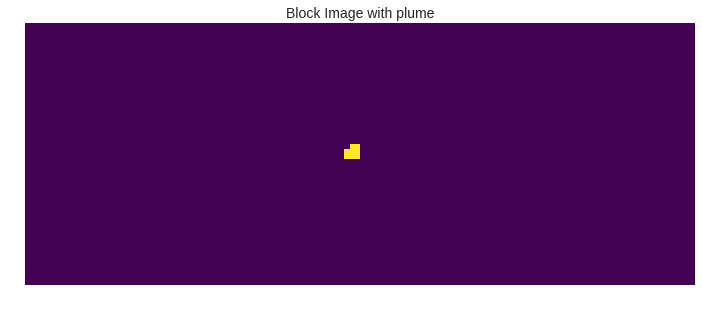

In [281]:
figure(figsize = (12, 12))
imshow(imbin[141], cmap = 'viridis')
title('Block Image with plume', size = 14)
axis('off')
grid(False)


In [220]:
label

array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0

In [221]:
blk = np.zeros((nimgs, 50, 128))
lbl = np.zeros(nimgs)
for k in range(nimgs):
    for i, x in enumerate(xrange(0,imbin[k].shape[0],26)):
        for j, y in enumerate(xrange(0,imbin[k].shape[1],32)):
            view = imbin[k,x:x+26, y:y+32]
            blk[k,i,j] = np.where(view.sum() > 130, 1., 0.)
            if blk[k].sum() >= 2. and blk[k].sum() < 30:
                lbl[k] = 1.

In [133]:
t = np.zeros(nimgs/10)
v = np.empty_like(t)
for i, j in enumerate(xrange(0, nimgs, 10)):
    v[i] = imvar[j:j+10].var()
    t[i] = i

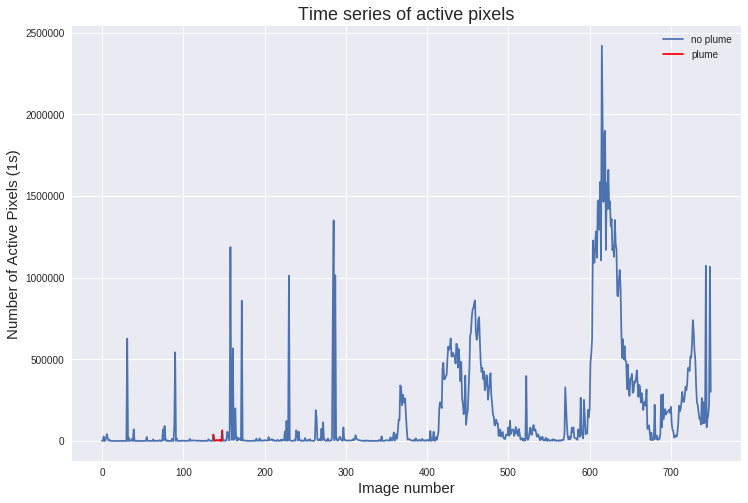

In [163]:
t2 = np.arange(750)
figure(figsize = (12, 8))
plot(t2,imvar)
plot(t2[137:149],imvar[137:149], color = 'r')
xlabel('Image number', size = 15)
ylabel('Number of Active Pixels (1s)', size = 15)
title('Time series of active pixels', size = 18)
legend(['no plume', 'plume'])

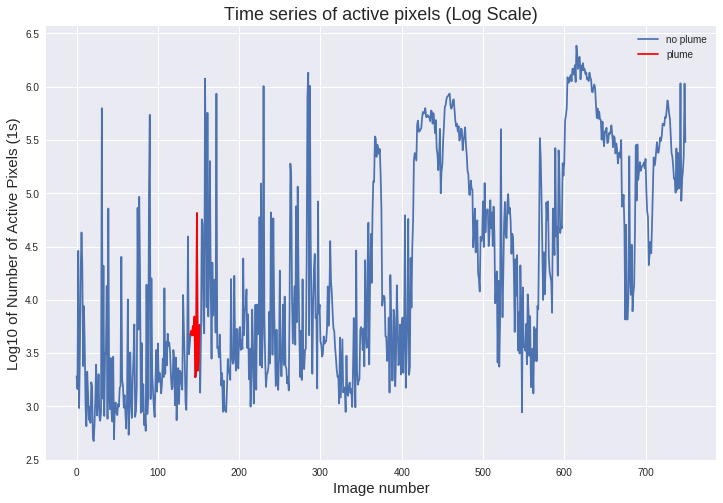

In [191]:

figure(figsize = (12, 8))
plot(t2,np.log10(imvar))
plot(t2[137:148],np.log10(imvar[137:148]), color = 'r')
xlabel('Image number', size = 15)
ylabel('Log10 of Number of Active Pixels (1s)', size = 15)
title('Time series of active pixels (Log Scale)', size = 18)
legend(['no plume', 'plume'])

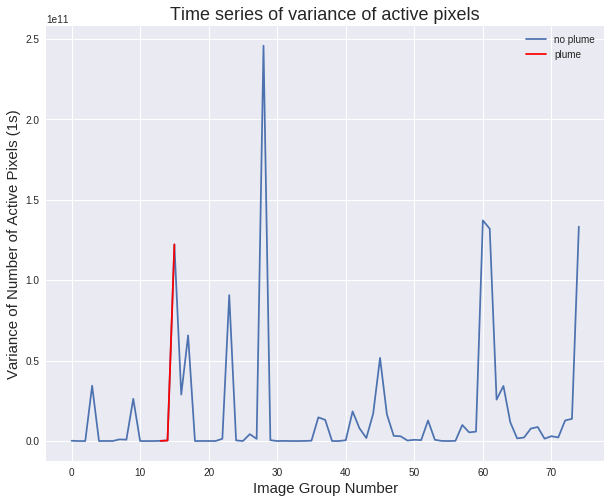

In [223]:
figure(figsize = (10,8))
plot(t,v)
plot(t[13:16],v[13:16], color = 'r')
xlabel('Image Group Number', size = 15)
ylabel('Variance of Number of Active Pixels (1s)', size = 15)
title('Time series of variance of active pixels', size = 18)
legend(['no plume', 'plume'])

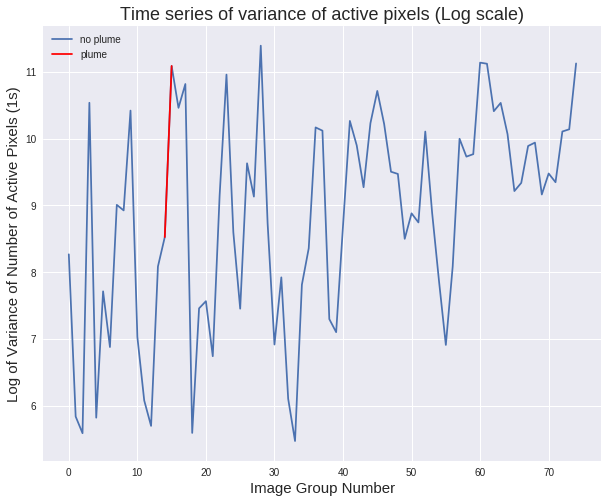

In [175]:
figure(figsize = (10,8))
plot(t,np.log10(v))
plot(t[14:16],np.log10(v[14:16]), color = 'r')
xlabel('Image Group Number', size = 15)
ylabel('Log of Variance of Number of Active Pixels (1s)', size = 15)
title('Time series of variance of active pixels (Log scale)', size = 18)
legend(['no plume', 'plume'])

In [248]:
X = imbin[137:149]
Xt = np.empty((12, 5324800))
for i in range(12):
    Xt[i] = X[i].flatten()

In [252]:
Xt.T

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [9]:
import cv2

In [12]:
#test = open('m3sd', 'w')
#test.writelines((imgpath1[68:] , 3 , 'g'))
#test.close()

In [18]:
#tmp2 = pd.read_csv('/wingrdp/homedirs/ir729/cuip/cuip/plumes/tmp2', header = None)
#tmp3 = pd.read_csv('/wingrdp/homedirs/ir729/cuip/cuip/plumes/tmp3', header = None)
m = pd.read_csv('mean', header = None, index_col = None)


In [22]:
def read_and_plot(data_csv):
    df = pd.read_csv(data_csv, header = None, index_col = None)
    df[0] = np.array([int(l[12:16].strip().split()[0]) for l in df[0]])
    
    lanbN = np.array(df[1], dtype = float)

    lanbS = np.array(df[2], dtype = float)
    lanbNS = np.array(df[3], dtype = float)

    scatter(lanbN,lanbS, c=df[0]*1.0/max(df[0]))

    ls1  = df[0][135:155]

    ls4  = lanbNS[135:155]

    ls3  = lanbN[135:155]

    ls2  = lanbS[135:155]

    scatter(ls1, ls3, c='k')


    scatter(df[0],lanbS, c=df[0]*1.0/max(df[0]))

    scatter(ls1, ls2, c='k')

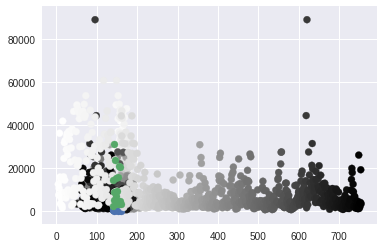

In [164]:

lanbN = np.array(m[1], dtype = float)

lanbS = np.array(m[2], dtype = float)
lanbNS = np.array(m[3], dtype = float)

scatter(lanbN,lanbS, c=m[0]*1.0/max(m[0]))

ls1  = m[0][135:155]

ls4  = lanbNS[135:155]

ls3  = lanbN[135:155]

ls2  = lanbS[135:155]

scatter(ls1, ls3)


scatter(m[0],lanbS, c=m[0]*1.0/max(m[0]))

scatter(ls1, ls2)

In [360]:
labs = open('m2sd', 'r').readlines()

In [389]:
labs[0].strip().split()[2]

'34'

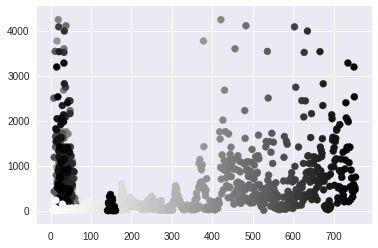

In [165]:
read_and_plot('m3sd')

In [37]:
a = np.array([[1,1,1,0,0,0,0],
              [1,0,0,1,0,0,1],
              [1,1,0,0,1,1,1],
              [0,0,0,1,0,1,1]])

In [189]:
tmp2 = rebin(imgs[145], (imgs[139].shape[0]/4, imgs[139].shape[1]/4))
imgtmp = tmp2.copy()
imgtmp[tmp2<8]=0
imgtmp[imgtmp>0]=1


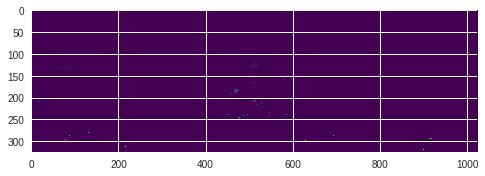

In [184]:
imshow(labels, cmap = 'viridis')

In [190]:
labels, lb2 = ndimage.measurements.label(imgtmp)

labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
#labtmp = {}
#for i in range(labels.max()+1):
#    labtmp[i] = labelsize[i]

#zeros = np.zeros_like(imgtmp.flatten())
labs = np.unique(labelsize)
labdiff = np.diff(np.unique(labelsize))
print len(labs),",", np.max(labdiff[:-1]),",", (labdiff>=50).sum()
#for i,z in enumerate(labels.flat):
#    if (labtmp[z]>20) * (labtmp[z]<1000) : 
        #print (labtmp[z])
#        zeros[i]=labtmp[z]

9 , 161 , 3


In [186]:
np.max(labdiff[:-1])

87

In [194]:
labs

array([     1,      2,      3,      4,      6,      7,    168,    236,
       332269])

In [214]:
with open('th10','w') as s:
    for i in range(10):
        s.write(str([i,i+1]))
    